# This is an exercise in using Vega-Lite and Altair API to visualize some of the obtained results. 

### Preface 
In order to take advantage of the Altair API, the corresponding library has to be added to the environment "cognoma-machine-learning". To that end, the file environment.yml in the root directory of the "machine-learning" repo has to be modified:
```
- pip:
  ...
  - altair==1.2.0
```
After that, the environment has to be recreated, by running two commands in the shell terminal, __from the root directory of the "machine-learning" repo__:
```
conda remove --name cognoma-machine-learning --all
conda env create -f environment.yml
```

### Part 1: Recreate the previous result with Seaborn
Now we are ready to proceed. As a starting point, we make an attempt to recreate the heatmap that shows the connection between different types of cancer and various gene mutations. This has been originally done in "3.TCGA-MLexample_Pathway.ipynb" so the first part of this notebook simply replicates those steps in order to create the original heatmap using Seaborn.

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad
from neo4j.v1 import GraphDatabase
%matplotlib inline
plt.style.use('seaborn-notebook')

#### Specify model configuration - Generate genelist

In [2]:
names = ('label', 'rel_type', 'node_id')
query_params = [
    ('Pathway', 'PARTICIPATES_GpPW', 'PC7_7459'),             # "Signaling by Hippo" - Reactome
    ('BiologicalProcess', 'PARTICIPATES_GpBP', 'GO:0035329'), # "hippo signaling" - Gene Ontology
    ('BiologicalProcess', 'PARTICIPATES_GpBP', 'GO:0035330')  # "regulation of hippo signaling" - Gene Ontology
]

param_list = [dict(zip(names, qp)) for qp in query_params]

In [3]:
query = '''
MATCH (node)-[rel]-(gene)
WHERE node.identifier = {node_id}
  AND {label} in labels(node)
  AND {rel_type} = type(rel)
RETURN
  gene.identifier as entrez_gene_id,
  gene.name as gene_symbol
ORDER BY gene_symbol
'''

In [4]:
driver = GraphDatabase.driver("bolt://neo4j.het.io")
full_results_df = pd.DataFrame()
with driver.session() as session:
    for parameters in param_list:
        result = session.run(query, parameters)
        result_df = pd.DataFrame((x.values() for x in result), columns=result.keys())
        full_results_df = full_results_df.append(result_df, ignore_index=True)

classifier_genes_df = full_results_df.drop_duplicates().sort_values('gene_symbol').reset_index(drop=True)
classifier_genes_df['entrez_gene_id'] = classifier_genes_df['entrez_gene_id'].astype('str')

In [5]:
# Here are the genes that participate in the Hippo signaling pathway
classifier_genes_df

,entrez_gene_id,gene_symbol
0,84962,AJUBA
1,154796,AMOT
2,154810,AMOTL1
3,51421,AMOTL2
4,836,CASP3
5,8642,DCHS1
6,1856,DVL2
7,79633,FAT4
8,9113,LATS1
9,26524,LATS2


#### Load Data

In [8]:
%%time
path = os.path.join('../../download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 3min 53s, sys: 12.1 s, total: 4min 6s
Wall time: 4min 19s


In [9]:
%%time
path = os.path.join('../../download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 2min 13s, sys: 7.5 s, total: 2min 20s
Wall time: 2min 23s


In [10]:
%%time
path = os.path.join('../../download', 'samples.tsv')
clinical = pd.read_table(path, index_col=0)

CPU times: user 29 ms, sys: 4.25 ms, total: 33.3 ms
Wall time: 144 ms


In [11]:
# Subset the Y matrix to only the genes to be classified
y_full = Y[classifier_genes_df['entrez_gene_id']]

In [12]:
y_full.columns = classifier_genes_df['gene_symbol']
y_full = y_full.assign(disease = clinical['disease'])

# This matrix now stores the final y matrix for the classifier (y['indicator'])
y = y_full.assign(indicator = y_full.max(axis=1))

In [13]:
unique_pos = y.groupby('disease').apply(lambda x: x['indicator'].sum())
heatmap_df0 = y_full.groupby('disease').sum().assign(TOTAL = unique_pos)
heatmap_df = heatmap_df0.divide(y_full.disease.value_counts(sort=False).sort_index(), axis=0)

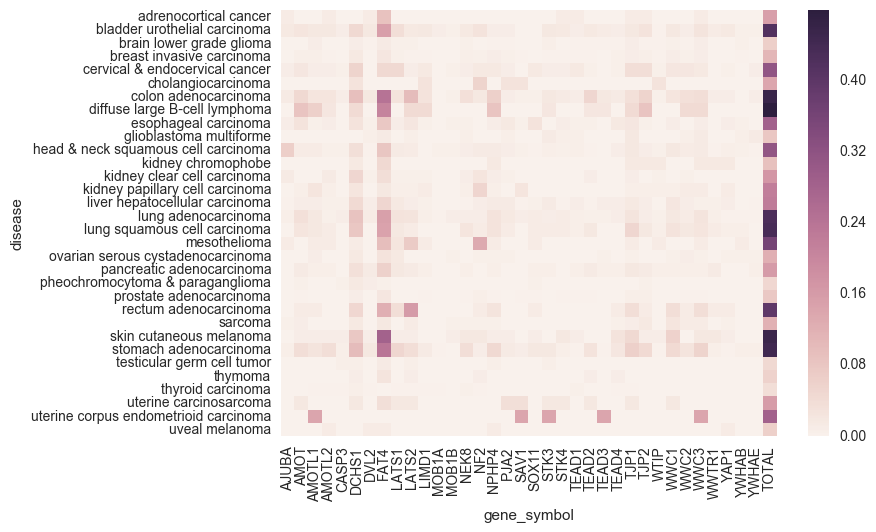

In [14]:
# What is the percentage of different mutations across different cancer types?
sns.heatmap(heatmap_df);

### Part 2: Building a Heatmap using Vega-Lite/Altair API

In order to take advantage of the Altair API, we have to covert the data into the so called long format (often referred to as the tidy format).

In [15]:
# Stack it: 
heatmap_df_stacked = heatmap_df.stack()
heatmap_df_stacked.head()

disease                gene_symbol
adrenocortical cancer  AJUBA          0.012821
                       AMOT           0.000000
                       AMOTL1         0.000000
                       AMOTL2         0.012821
                       CASP3          0.000000
dtype: float64

In [16]:
# Convert into the Pandas dataframe
df000 = pd.DataFrame(heatmap_df_stacked)
df000.head(4)

0
disease               gene_symbol          
adrenocortical cancer AJUBA        0.012821
                      AMOT         0.000000
                      AMOTL1       0.000000
                      AMOTL2       0.012821

In [17]:
# Fix the index: Get rid of Multilevel
df111 = df000.reset_index(level=['disease', 'gene_symbol'])
df111.head()

,disease,gene_symbol,0
0,adrenocortical cancer,AJUBA,0.012821
1,adrenocortical cancer,AMOT,0.000000
2,adrenocortical cancer,AMOTL1,0.000000
3,adrenocortical cancer,AMOTL2,0.012821
4,adrenocortical cancer,CASP3,0.000000


In [19]:
# Give the third column a meaningful name: 'count'
df111.columns = ['disease', 'gene_symbol', 'count']
df111.head()

,disease,gene_symbol,count
0,adrenocortical cancer,AJUBA,0.012821
1,adrenocortical cancer,AMOT,0.000000
2,adrenocortical cancer,AMOTL1,0.000000
3,adrenocortical cancer,AMOTL2,0.012821
4,adrenocortical cancer,CASP3,0.000000


###  Now we are ready to build the new heatmap

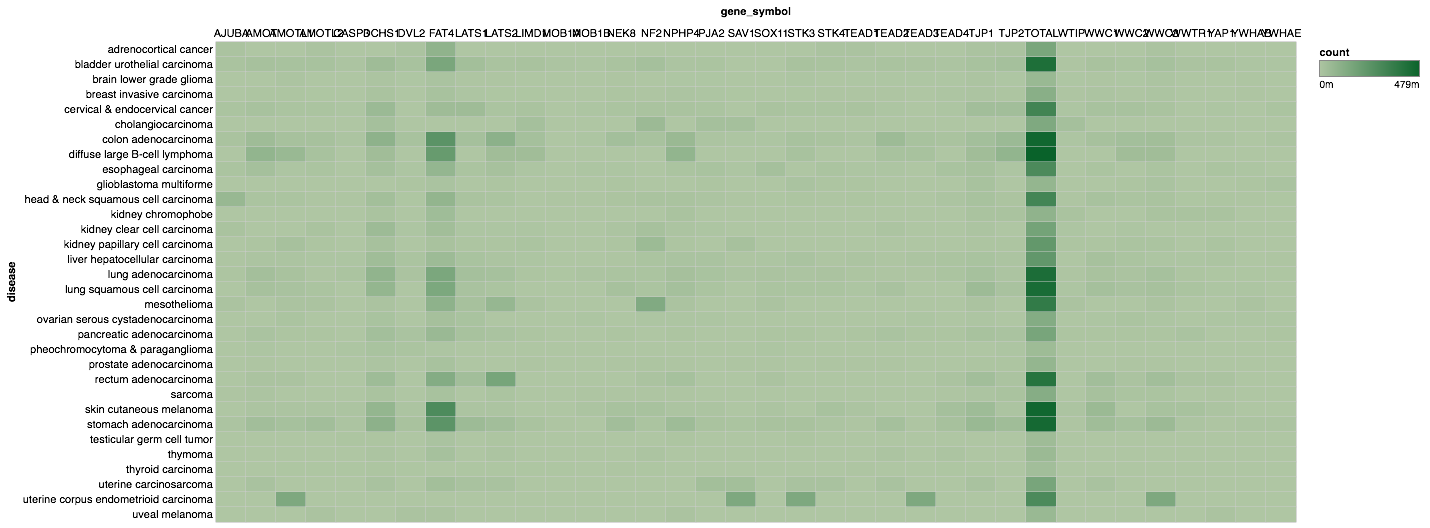

In [20]:
from altair import Row, Column, Chart, Text

def heatmap(data, row, column, color, cellsize=(30, 15)):
    """Create an Altair Heat-Map

    Parameters
    ----------
    row, column, color : str
        Altair trait shorthands
    cellsize : tuple
        specify (width, height) of cells in pixels
    """
    return Chart(data).mark_text(
               applyColorToBackground=True,
           ).encode(
               row=row,
               column=column,
               text=Text(value=' '),
               color=color
           ).configure_scale(
               textBandWidth=cellsize[0],
               bandSize=cellsize[1]
           )
heat = heatmap(df111, column='gene_symbol', row='disease', color='count')
heat

There are clearly some issues with the figure format, which proved difficult to fix at the first attempt. In order to address this problem, the changes have been made directly in the JSON file. At this intial stage, it appears reasonable to edit the JSON data in Vega-Lite editor, due to a limited functionality of Altair API (as well as the author's lack of experience with Altair). 

The following is the edited version JSON file produced in the previous cell. Since the main focus of this exercise is the figure formating, the actual data has been removed (See "values": [.......]).
* To improve the appearance of the column labels, an attribute "axis" has been added, with two sub-attributes: "labelAngle" (rotates the labels), and "offset" (shifts the labels vertically).
* More exploring needs to be done...

In [ ]:
{
  "mark": "text",
  "encoding": {
    "column": {
      "field": "gene_symbol",
      "type": "nominal",
      "axis": {"labelAngle": -90,
        "offset": 25
      }
    },
    "text": {"value": " "},
    "row": {"field": "disease","type": "nominal"},
    "color": {"field": "count","type": "quantitative"}
  },
  "config": {
    "mark": {"applyColorToBackground": true},
    "cell": {"width": 500,"height": 350},
    "scale": {"textBandWidth": 30,"bandSize": 15}
  },
  "data": {
    "values": [.......]
  }
}